# EfficientNetB0_Flat_repair_version
Построение модели классификации ремонта без изображений экстерьера с помощью  модели EfficientNetB0 с oversampling и аугментацией изображений

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import efficientnet 
%matplotlib inline
from matplotlib import pyplot as plt
import os
from random import shuffle
from glob import glob
from tqdm import tqdm
import shutil
import zipfile
import albumentations as A

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
repair_types = [
    'no_repair',
    'cosmetic',
    'euro',
    'designer',
    ]

In [5]:
def define_repair(path, out='index'):
  for repair_type in repair_types:
    if os.path.basename(path).startswith(repair_type):
      if out == 'index':
        return repair_types.index(repair_type)
      return repair_type

In [6]:
# импортируем данные с метками
file = 'interior_data_v3_splitted.zip'
shutil.copy(f'/content/drive/MyDrive/Colab Notebooks/{file}', f'{file}')
zip_file = f'/content/{file}'
z= zipfile.ZipFile(zip_file)
z.extractall()

files = glob('/content/interior_data_v3_splitted/*/*.jpg')
len(files)

15664

In [7]:
class_balance = { repair_type: 0 for repair_type in repair_types}

for file in files:
  for repair_type in repair_types:
    if os.path.basename(file).startswith(repair_type):
      class_balance[repair_type] += 1

class_balance

{'cosmetic': 4070, 'designer': 3972, 'euro': 4655, 'no_repair': 2967}

In [8]:
transform = A.Compose([
    A.OneOf([
              A.RandomCrop(p=0.1, width=300, height=300),
              A.HorizontalFlip(p=0.8),
              A.RandomBrightness(limit=0.4, p=0.6),
        ], p=1) 
])

In [9]:
def plot_images(image1, image2):
  fig = plt.figure(figsize=(16, 8))
  subplot = fig.add_subplot(1, 2, 1)
  subplot.set_title(f"original")
  plt.imshow(image1)
  subplot = fig.add_subplot(1, 2, 2)
  subplot.set_title(f"augmented")
  plt.imshow(image2)
  plt.show()

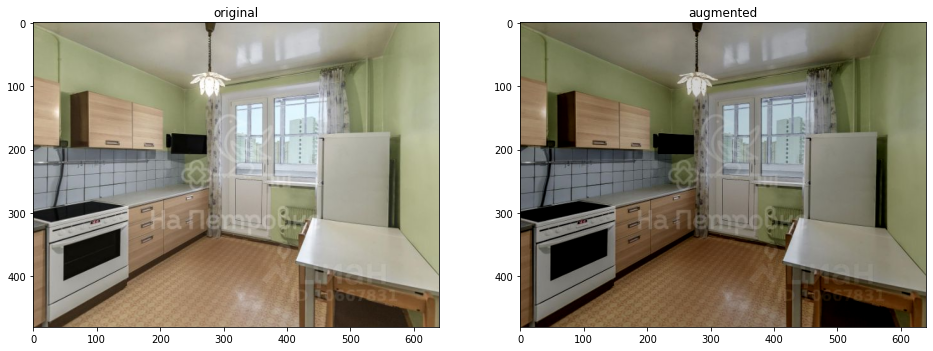

In [13]:
path = np.random.choice(files)
image = cv2.imread(path)[...,::-1]
transformed = transform(image=image)
transformed_image = transformed["image"]
plot_images(image, transformed_image)

# Разделение на валидационную выборку

In [15]:
train_files = glob('/content/interior_data_v3_splitted/train/*.jpg')
test_files = glob('/content/interior_data_v3_splitted/test/*.jpg')
len(train_files), len(test_files)

(10964, 4700)

In [ ]:
from sklearn.model_selection import train_test_split
file_labels = [define_repair(file) for file in train_files]
train_files, validation_files = train_test_split(train_files, test_size=0.2, stratify=file_labels, random_state=0)
len(train_files), len(validation_files)

(8771, 2193)

# Папка для валидации

In [ ]:
# делаем папки для валидации 
root_path = 'interior_data_v3_splitted'
path_to_train = f'{root_path}/validation/'
# os.mkdir(root_path)
os.mkdir(path_to_train)

for file in validation_files:
  file_name = os.path.basename(file)
  new_path = f'{root_path}/validation/{file_name}'
  shutil.copy(file, new_path)

# Новая папка для трейна с аугментацией и оверсэмплингом

In [ ]:
# делаем папки 
root_path = 'interior_data_v3_splitted'
path_to_train = f'{root_path}/train_new/'
# os.mkdir(root_path)
os.mkdir(path_to_train)
for file in train_files:
  file_name = os.path.basename(file)
  new_path = f'{root_path}/train_new/{file_name}'
  shutil.copy(file, new_path)

In [ ]:
train_files = glob('/content/interior_data_v3_splitted/train_new/*.jpg')
validation_files = glob('/content/interior_data_v3_splitted/validation/*.jpg')
len(train_files), len(validation_files)

(23823, 2193)

In [16]:
class_balance = {repair_type: 0 for repair_type in repair_types}

for file in train_files:
  for repair_type in repair_types:
    if os.path.basename(file).startswith(repair_type):
      class_balance[repair_type] += 1

class_balance

{'cosmetic': 2849, 'designer': 2780, 'euro': 3258, 'no_repair': 2077}

In [ ]:
%%time
target_size = 10000
for repair_type in repair_types:
  repair_files = glob(f'/content/interior_data_v3_splitted/train_new/{repair_type}*.jpg')
  counter = 0 # считаем, сколько добавили
  while counter < target_size - class_balance[repair_type]:
    file = np.random.choice(repair_files)
    image = cv2.imread(file)[...,::-1]
    transformed = transform(image=image)
    transformed_image = transformed["image"]
    # plot_images(image, transformed_image)
    file_name = os.path.basename(file)
    file_name_no_jpg = file_name.split('.')[0]
    rand1 = np.random.randint(0, 100)
    rand2 = np.random.randint(0, 100)
    name_parts = []
    name_parts.append(file_name_no_jpg)
    name_parts.append(f'transformed_{rand1}_{rand2}.jpg')
    new_file_name = '_'.join(name_parts)
    new_file_path = path_to_train + new_file_name
    cv2.imwrite(new_file_path, transformed_image[...,::-1])
    counter += 1
  print(f'For {repair_type} augmentation done')

For no_repair augmentation done
For cosmetic augmentation done
For euro augmentation done
For designer augmentation done
CPU times: user 3min 9s, sys: 4.98 s, total: 3min 14s
Wall time: 3min 13s


In [ ]:
train_files = glob('/content/interior_data_v3_splitted/train_new/*.jpg')
len(train_files)

39999

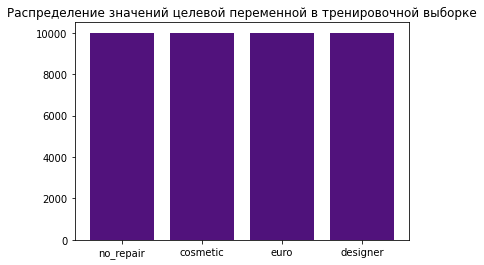

In [ ]:
class_balance = { repair_type: 0 for repair_type in repair_types}

for file in train_files:
  for repair_type in repair_types:
    if os.path.basename(file).startswith(repair_type):
      class_balance[repair_type] += 1

my_cmap = plt.cm.get_cmap('magma')
data_color_normalized = [x / sum(class_balance.values()) for x in class_balance.values()]

colors = my_cmap(data_color_normalized)

ax = plt.axes()
plt.bar(x=class_balance.keys(), height=class_balance.values(), color=colors)
ax.set_title("Распределение значений целевой переменной в тренировочной выборке")
plt.show()

In [ ]:
train_files = glob('/content/interior_data_v3_splitted/train_new/*.jpg')
validation_files = glob('/content/interior_data_v3_splitted/validation/*.jpg')
test_files = glob('/content/interior_data_v3_splitted/test/*.jpg')
len(train_files), len(validation_files), len(test_files)

(39999, 2193, 4700)

## Функции загрузки данных

In [ ]:
IMG_SIZE = (224, 224)  # размер входного изображения сети
batch_size = 32

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return efficientnet.preprocess_input(img) # предобработка для efficientnet

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=batch_size):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([define_repair(path) for path in files[i:j]])
            y_labels = tf.keras.utils.to_categorical(y, num_classes=4)
            yield (x, y_labels)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

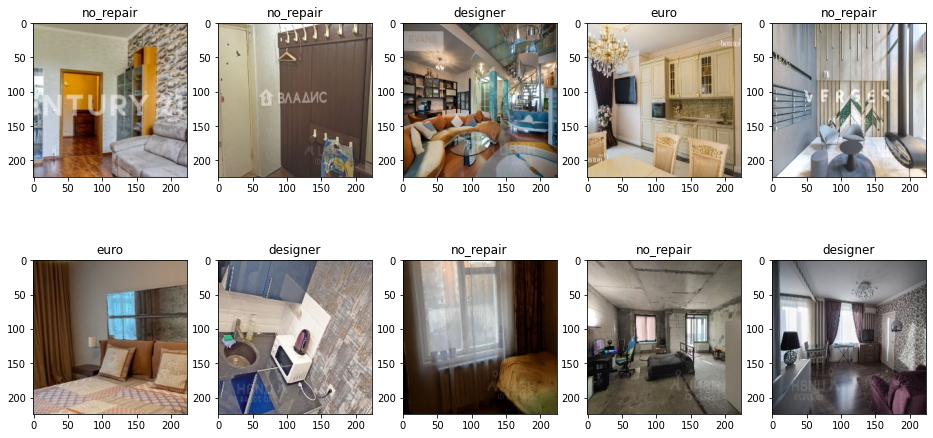

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title(f"{define_repair(path, out='label')}")
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

# Загружаем предобученную модель

In [ ]:
base_model = efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

16719872/16705208 [==============================] - 0s 0us/step


## Добавляем слои

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output  # последний слой EfficientNetB0
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(4,  # 4 класса
                          activation='softmax',  # функция активации  
                          )(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='EfficientNetB0_flat_repair_type_v2')

## Выводим архитектуру модели

In [ ]:
model.summary()

Model: "EfficientNetB0_flat_repair_type_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           

## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # функция потерь
              metrics=['accuracy'])

In [ ]:
%%time
num_iters = int(len(train_files) / (batch_size*4)) 
val_samples = 200  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(validation_files, val_samples))
train_data = fit_generator(train_files)  # данные читаем функцией-генератором

# запускаем процесс обучения
history = model.fit(train_data,
          steps_per_epoch=num_iters,  # число вызовов генератора за эпоху
          epochs=30,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/30
312/312 [==============================] - 84s 226ms/step - loss: 1.5856 - accuracy: 0.4001 - val_loss: 1.2787 - val_accuracy: 0.3850
Epoch 2/30
312/312 [==============================] - 69s 221ms/step - loss: 1.2163 - accuracy: 0.4623 - val_loss: 1.2533 - val_accuracy: 0.3700
Epoch 3/30
312/312 [==============================] - 69s 221ms/step - loss: 1.1503 - accuracy: 0.4736 - val_loss: 1.2718 - val_accuracy: 0.4300
Epoch 4/30
312/312 [==============================] - 69s 222ms/step - loss: 1.1128 - accuracy: 0.4965 - val_loss: 1.1879 - val_accuracy: 0.3950
Epoch 5/30
312/312 [==============================] - 68s 219ms/step - loss: 1.0776 - accuracy: 0.5202 - val_loss: 1.2418 - val_accuracy: 0.4200
Epoch 6/30
312/312 [==============================] - 68s 220ms/step - loss: 1.0636 - accuracy: 0.5225 - val_loss: 1.2118 - val_accuracy: 0.4100
Epoch 7/30
312/312 [==============================] - 68s 219ms/step - loss: 1.0621 - accuracy: 0.5238 - val_loss: 1.2074 - val_ac

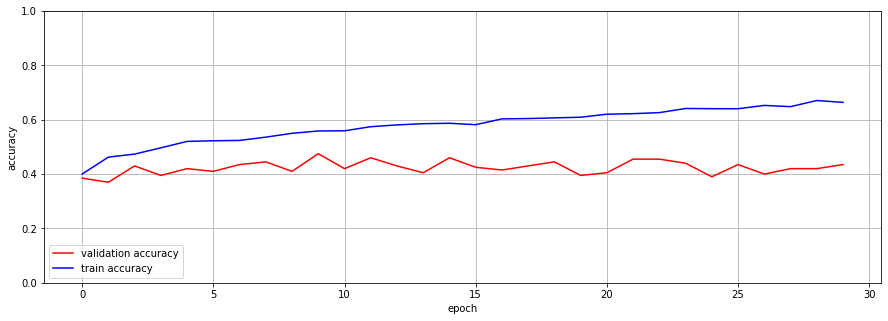

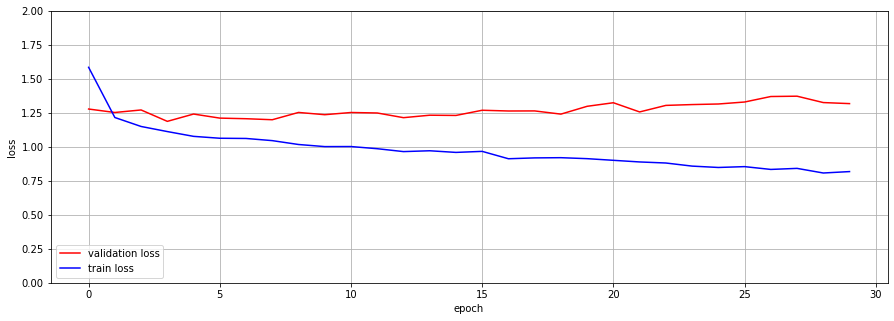

In [ ]:
def accuracy_plot(model):
    plt.figure(figsize=(15,5))
    plt.plot(model.history['val_accuracy'],'r',label='validation accuracy')
    plt.plot(model.history['accuracy'],'b',label='train accuracy')   
    plt.ylabel('accuracy')
    plt.xlabel('epoch')  
    plt.legend(loc="lower left")    
    axes = plt.gca()
    axes.set_ylim([0,1])
    plt.grid()
    plt.show()

def loss_plot(model):
    plt.figure(figsize=(15,5))
    plt.plot(model.history['val_loss'],'r',label='validation loss')
    plt.plot(model.history['loss'],'b',label='train loss')   
    plt.ylabel('loss')
    plt.xlabel('epoch')  
    plt.legend(loc="lower left")
    axes = plt.gca()
    axes.set_ylim([0,2])
    plt.grid()
    plt.show()

accuracy_plot(history)
loss_plot(history)

In [ ]:
# сохраняем
model_name = 'efficientnet_flat_repair_type_v5_augmentation_dropout_07.hdf5'
model.save(model_name)

# сохраняем на google диск
shutil.copy(f'/content/{model_name}', f'/content/drive/MyDrive/Colab Notebooks/{model_name}')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Предсказания на проверочной выборке

In [ ]:
%%time
N = 24 # количество файлов для просмотра 
rand_test_files = np.random.choice(test_files, size=N)
test_pred = model.predict(
    predict_generator(rand_test_files), steps=N)

CPU times: user 2.12 s, sys: 36.8 ms, total: 2.16 s
Wall time: 1.95 s


In [ ]:
fig = plt.figure(figsize=(20, 5*int(N / 4)))
for i, (path, score) in enumerate(zip(rand_test_files, test_pred), 1):
    subplot = fig.add_subplot(int(N / 4), 4, i)
    position = np.argmax(score)
    repair_type = repair_types[position]
    # exterior_type = position_to_class[position]
    true_val = define_repair(path, out='label')
    subplot.set_title(f'predicted:{repair_type} true:{true_val}')
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%%time
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

CPU times: user 1min 51s, sys: 2.13 s, total: 1min 53s
Wall time: 1min 21s


In [ ]:
y_test = np.array([define_repair(path) for path in test_files])
y_pred = np.array([np.argmax(score) for score in test_pred])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_score(y_pred, y_test) #0.4672340

0.45914893617021274

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.62       890
           1       0.40      0.38      0.39      1221
           2       0.41      0.40      0.41      1397
           3       0.46      0.48      0.47      1192

    accuracy                           0.46      4700
   macro avg       0.47      0.47      0.47      4700
weighted avg       0.46      0.46      0.46      4700



In [ ]:
confusion_matrix(y_test,y_pred)

array([[565, 173,  76,  76],
       [205, 461, 363, 192],
       [101, 329, 558, 409],
       [ 65, 194, 359, 574]])

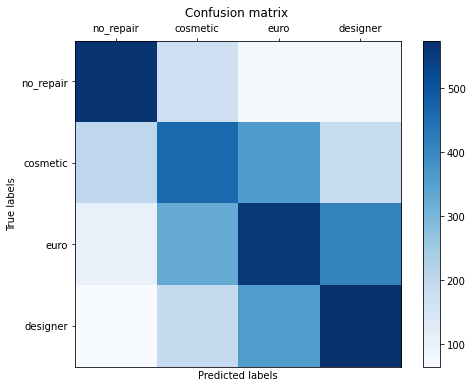

In [ ]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
plt.imshow(cm, cmap=plt.cm.Blues ,)
plt.xlabel("Predicted labels", )
plt.ylabel("True labels")
plt.xticks([0,1,2,3], ['no_repair', 'cosmetic', 'euro', 'designer'], )
plt.yticks([0,1,2,3], ['no_repair', 'cosmetic', 'euro', 'designer'])
plt.title('Confusion matrix ')
ax.xaxis.set_ticks_position('top')
plt.colorbar()
plt.show()